In [2]:
import sklearn
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=100, n_features=1, noise=15.0, random_state=42)


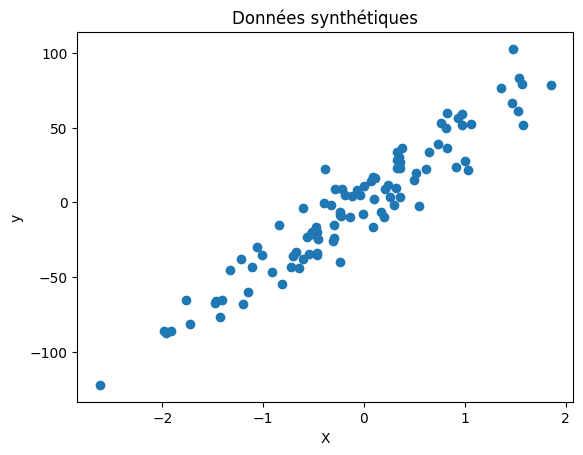

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.title("Données synthétiques")
plt.xlabel("X")
plt.ylabel("y")
plt.show()


In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
print("θ₀ (intercept) :", model.intercept_)
print("θ₁ (coef)      :", model.coef_[0])


θ₀ (intercept) : 1.7476729807904583
θ₁ (coef)      : 45.785204830943506


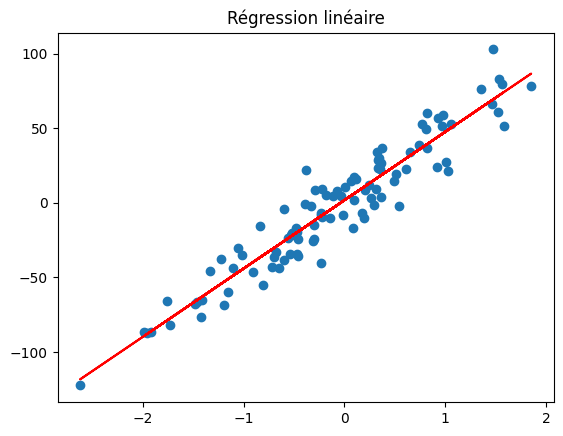

In [6]:
y_pred = model.predict(X)
plt.scatter(X, y)
plt.plot(X, y_pred, color="red")
plt.title("Régression linéaire")
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"MSE = {mse:.2f}, R² = {r2:.2f}")


MSE = 175.62, R² = 0.91


**Jour 9** – Régression logistique & métriques de classification



In [10]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    class_sep=1.5,
    random_state=0
)


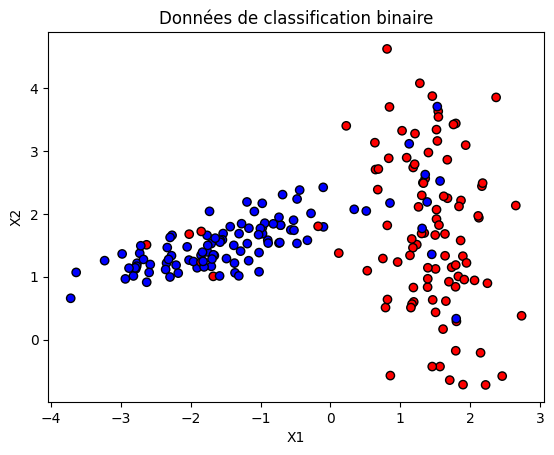

In [11]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
plt.title("Données de classification binaire")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X, y)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [13]:
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:,1]  # probabilité d’appartenir à la classe 1


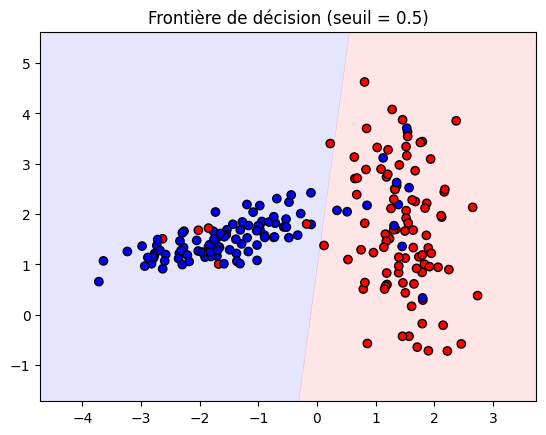

In [14]:
import numpy as np

# Crée une grille pour X1, X2
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:,1].reshape(xx.shape)

plt.contourf(xx, yy, probs, levels=[0,0.5,1], alpha=0.2, cmap='bwr')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
plt.title("Frontière de décision (seuil = 0.5)")
plt.show()


In [15]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"Accuracy  : {acc:.2f}")
print(f"Precision : {prec:.2f}")
print(f"Recall    : {rec:.2f}")
print(f"F1-score  : {f1:.2f}")
print("Matrice de confusion :\n", cm)


Accuracy  : 0.91
Precision : 0.89
Recall    : 0.92
F1-score  : 0.91
Matrice de confusion :
 [[90 11]
 [ 8 91]]


**Jour 10 — Arbres de décision, Random Forest, SVM**

**Objectifs**

* Comprendre comment un arbre de décision prend des décisions (noeuds, feuilles).

* Savoir calculer et interpréter Gini et entropie (critères de séparation).

* Savoir pourquoi un arbre sur-apprend (overfitting) et comment le contrôler (profondeur, min_samples).

* Comprendre l’idée de Random Forest (bagging + variables aléatoires) et pourquoi ça réduit l’overfitting.

* Avoir une intuition sur les SVM (marge maximale, noyaux/kernel).

* Implémenter et comparer ces modèles avec scikit-learn sur un jeu de données simple.

**Chargement dataset (réutilise make_classification)**

In [24]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=300,       # nombre d'exemples (lignes)
    n_features=2,        # nombre total de caractéristiques (colonnes)
    n_informative=2,     # combien de ces caractéristiques sont réellement utiles pour séparer les classes
    n_redundant=0,       # combien sont des combinaisons linéaires des autres (ici aucune)
    class_sep=1.0,       # séparation entre les classes (plus grand = plus facilement séparables)
    random_state=42      # graine aléatoire pour rendre le jeu reproductible
)


* n_samples=300 : tu auras 300 lignes (300 exemples) dans X et 300 éléments dans y.

* n_features=2 : chaque exemple a 2 caractéristiques (donc X aura la forme (300, 2)).

→ Choix utile pour pouvoir tracer les points sur un plan (2D).

* n_informative=2 : sur les 2 caractéristiques, les 2 sont informatives (elles influencent réellement la classe).
Si n_informative < n_features, les autres colonnes peuvent être du bruit ou redondantes.

* n_redundant=0 : pas de caractéristiques qui sont des combinaisons linéaires d’autres (par ex. x3 = 2*x1 + x2).

* class_sep=1.0 : contrôle l’écart entre les nuages de points des deux classes.

* Valeur faible (ex. 0.5) → classes se chevauchent beaucoup (problème plus dur).

* Valeur grande (ex. 2.0) → classes bien séparées (plus facile).

* random_state=42 : fixe la graine aléatoire pour que chaque exécution retourne exactement les mêmes X et y. Utile pour reproduire les tests.

In [25]:
print(X.shape, y.shape) 

(300, 2) (300,)


In [26]:
import numpy as np
print(np.unique(y, return_counts=True))

(array([0, 1]), array([150, 150]))


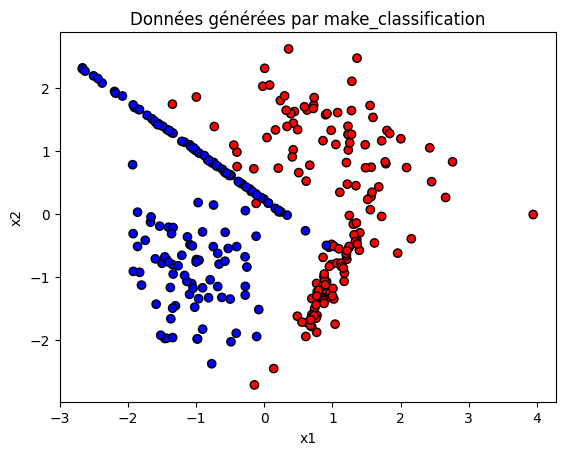

In [27]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Données générées par make_classification')
plt.show()


**Arbre de décision : entraînement et visualisation**

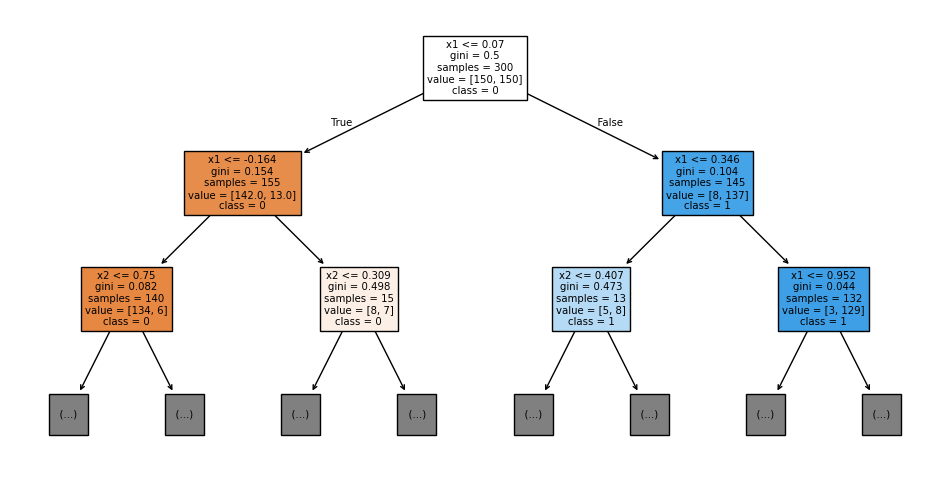

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
clf.fit(X, y)

# Visualiser l'arbre (simple)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plot_tree(clf, filled=True, feature_names=['x1','x2'], class_names=['0','1'], max_depth=2)
plt.show()


**Évaluer l’arbre**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        47
           1       0.93      0.95      0.94        43

    accuracy                           0.94        90
   macro avg       0.94      0.94      0.94        90
weighted avg       0.94      0.94      0.94        90



**Random Forest : entraînement et comparaison**

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_rf))


RF Accuracy: 0.9222222222222223


**Visualiser frontière de décision (pour comparaison)**

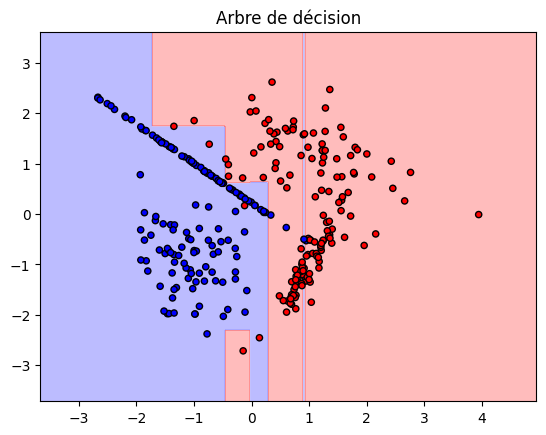

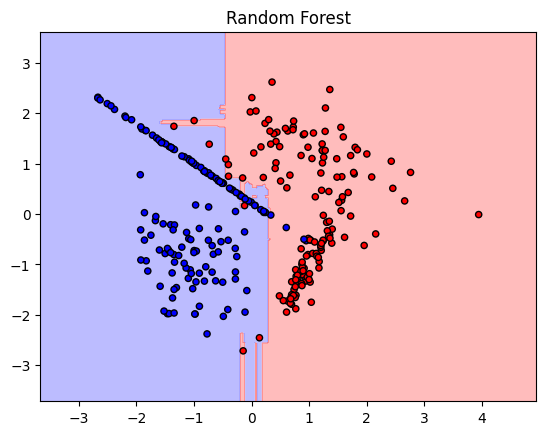

In [20]:
import numpy as np

def plot_decision_boundary(model, X, y, title):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', s=20)
    plt.title(title)
    plt.show()

plot_decision_boundary(clf, X, y, "Arbre de décision")
plot_decision_boundary(rf, X, y, "Random Forest")


**SVM (introduction)**

SVM Accuracy: 0.9555555555555556


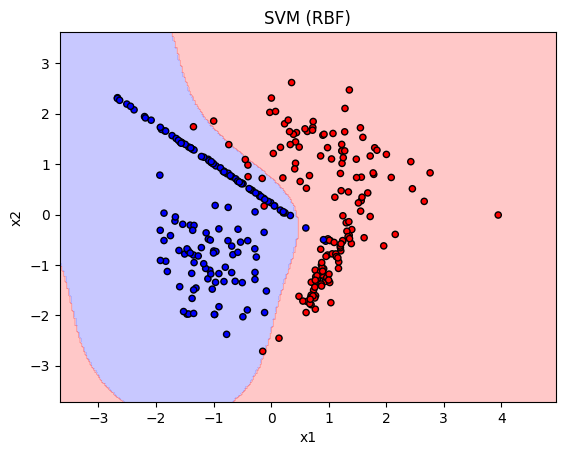

In [23]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_svm))
plot_decision_boundary(svm, X, y, "SVM (RBF)")


4) **Exercice concret (30 min)**
1. Utilise le dataset make_classification ci-dessus.

2. Fais 3 modèles : DecisionTree (tuned), RandomForest, SVM.

3. Pour chaque modèle :

* Calculer accuracy, precision, recall, f1.

* Tracer la frontière de décision.

4. Rédige 6–8 lignes dans un notebook : résumé des résultats et pourquoi un modèle est meilleur/quand l’utiliser.

DecisionTree - best params: {'max_depth': 5, 'min_samples_leaf': 5}
--- Decision Tree (tuned) ---
Train accuracy: 0.9523809523809523
Test  accuracy: 0.8555555555555555
Precision: 0.7777777777777778
Recall   : 0.9767441860465116
F1-score : 0.865979381443299
Confusion matrix:
 [[35 12]
 [ 1 42]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84        47
           1       0.78      0.98      0.87        43

    accuracy                           0.86        90
   macro avg       0.88      0.86      0.85        90
weighted avg       0.88      0.86      0.85        90



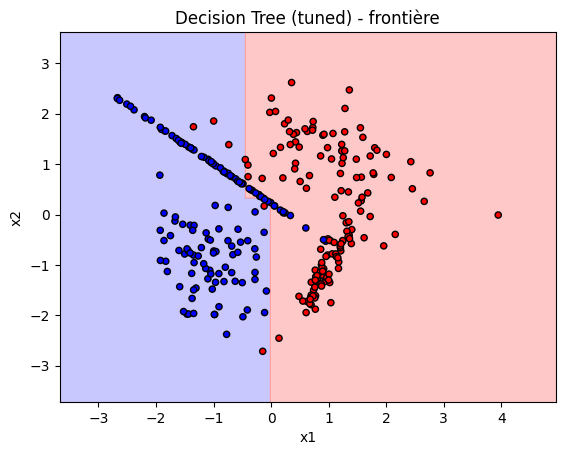

--- Random Forest ---
Train accuracy: 1.0
Test  accuracy: 0.9222222222222223
Precision: 0.8913043478260869
Recall   : 0.9534883720930233
F1-score : 0.9213483146067416
Confusion matrix:
 [[42  5]
 [ 2 41]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92        47
           1       0.89      0.95      0.92        43

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90



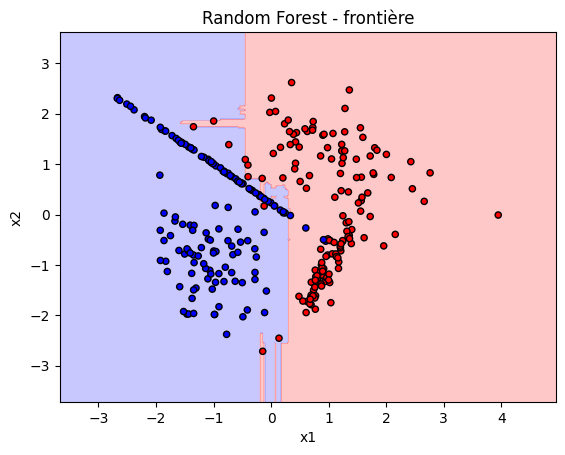

--- SVM (RBF w/ StandardScaler) ---
Train accuracy: 0.9619047619047619
Test  accuracy: 0.9555555555555556
Precision: 0.9534883720930233
Recall   : 0.9534883720930233
F1-score : 0.9534883720930233
Confusion matrix:
 [[45  2]
 [ 2 41]]
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.95      0.95      0.95        43

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



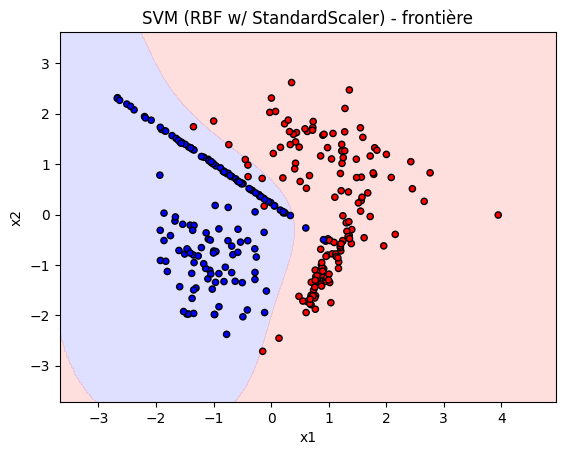

In [28]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Fonction utilitaire pour tracer frontière (gère scaler optionnel)
def plot_decision_boundary(model, X, y, title="Decision boundary", scaler=None, proba=False, grid_res=300):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_res), np.linspace(y_min, y_max, grid_res))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # si on a un scaler (pipeline), transformer la grille
    if scaler is not None:
        try:
            grid_t = scaler.transform(grid)
        except Exception:
            # si scaler est pipeline, il peut être appliqué directement
            grid_t = grid
    else:
        grid_t = grid
    try:
        if proba and hasattr(model, "predict_proba"):
            Z = model.predict_proba(grid_t)[:,1].reshape(xx.shape)
            plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.25, cmap='bwr')
        else:
            # pour pipeline avec scaler, model.predict accepte directement grid_t if pipeline was fit on scaled data
            Z = model.predict(grid_t).reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.25, cmap='bwr')
    except Exception as e:
        print("Erreur prédiction grille :", e)
        return
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# 1) Générer dataset
X, y = make_classification(n_samples=300, n_features=2, n_informative=2,
                           n_redundant=0, class_sep=1.0, random_state=42)

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# 3) Decision Tree (tuning avec GridSearchCV)
dt = DecisionTreeClassifier(random_state=0)
param_grid_dt = {
    'max_depth': [2, 5, None],
    'min_samples_leaf': [1, 5, 10]
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1')  # f1 pour classe équilibrée/importance balance
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("DecisionTree - best params:", grid_dt.best_params_)

# 4) Random Forest (simple, bon baseline)
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)
rf.fit(X_train, y_train)

# 5) SVM (avec StandardScaler)
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=0))
])
svm_pipe.fit(X_train, y_train)

# 6) Évaluation - fonction pour ne pas répéter
def evaluate_and_report(name, model, X_tr, y_tr, X_te, y_te, scaler_for_plot=None, proba_for_plot=False):
    y_pred = model.predict(X_te)
    y_pred_tr = model.predict(X_tr)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred)
    print(f"--- {name} ---")
    print("Train accuracy:", accuracy_score(y_tr, y_pred_tr))
    print("Test  accuracy:", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(y_te, y_pred))
    # tracer frontière ; si model est pipeline avec scaler, scaler_for_plot=None but model will accept raw grid if pipeline included scaler
    plot_decision_boundary(model, X, y, title=f"{name} - frontière", scaler=scaler_for_plot, proba=proba_for_plot)

# 7) Appliquer aux trois modèles
evaluate_and_report("Decision Tree (tuned)", best_dt, X_train, y_train, X_test, y_test, scaler_for_plot=None, proba_for_plot=False)
evaluate_and_report("Random Forest", rf, X_train, y_train, X_test, y_test, scaler_for_plot=None, proba_for_plot=False)
# pour SVM, le pipeline gère le scaler en interne => pour tracer la grille on doit transformer la grille avec scaler
evaluate_and_report("SVM (RBF w/ StandardScaler)", svm_pipe, X_train, y_train, X_test, y_test, scaler_for_plot=svm_pipe.named_steps['scaler'], proba_for_plot=True)
